# Week 8 - Neuromorphic Computing Exercise

One of the aim's of this course is to try to think outside of the box of either neuroscience or machine learning, and see what happens when we are inspired by what we know from both fields but don't limit ourselves to those possibilities. Neuromorphic computing is an opportunity to do this. We can think about what types of nonstandard neural networks we could implement that are well matched to neuromorphic hardware but that aren't just a translation of a standard model from neuroscience or machine learning.

In this week's class, we'll take an existing spiking neural network model for speech recognition ([Friedemann Zenke's SPyTorch tutorial 4](https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial4.ipynb)) and see how we can modify it and still be able to train it. You're welcome to try any idea you like. One option would be to simplify the neuron models to reduce their computational costs. For example, rather than exponential decay, what happens with just a linear decay? Limiting yourself to event-based models (like spiking neural networks) makes them naturally amenable to neuromorphic implementation, but you could think about what you could do with those events that isn't just spikes.

If you to try out an approach that definitely works rather than inventing your own, try linear decay. A good starting point is to subtract off ``time_step/tau_mem`` from the membrane potential at each time step. When I tried this, using a larger time step like 100 ms worked better than the 10 ms in the original notebook, but you can probably do better with some experimentation.

I've included below a version of SPyTorch tutorial 4 that will run on Google Colab and only take about 5 minutes to train, although to do this it only uses 10 epochs compared to the 200 epochs in the original tutorial, so the results are not as good of course. If you have a model you're happy with and enough time to spare, you could try scaling that up and see if you can beat the performance from Friedemann's tutorial, or even if you can make it to the top of the [Spiking Heidelberg Digits leaderboard](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/). If so, your model might even be publishable!

For those attending in person, at the end of the class we'll have a competition for both the model with best performance, and for the weirdest model that can still train to do well at the task. If you're joining online, feel free to post your performance numbers and a brief description of your model in our Discord.

## Mini-SPyTorch tutorial 4

This is a modified version of [SPyTorch tutorial 4](https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial4.ipynb) designed to reduce computation time and run on Google Colab. It uses the [SHD](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/) dataset. For background on the techniques and dataset, have a quick read of the tutorial. I'll keep the code and comments here as simple as possible.

### Imports and basic setup

In [1]:
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython import display

import torch
import torch.nn as nn
from torch.utils import data
from torch.nn.functional import relu

from tqdm.notebook import tqdm

In [2]:
dtype = torch.float
# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

### Load data

In [3]:
import urllib.request, gzip, shutil
base_url = "https://zenkelab.org/datasets"
files = ['shd_train.h5', 'shd_test.h5']
for filename in files:
    if not os.path.exists(filename):
        url = base_url+'/'+filename+'.gz'
        print(f'Downloading {url}')
        urllib.request.urlretrieve(url, filename+'.gz')
        with gzip.open(filename+'.gz', 'r') as f_in, open(filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [4]:
train_file = h5py.File('shd_train.h5', 'r')
test_file = h5py.File('shd_test.h5', 'r')

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']

### Batching and iterating

In [5]:
def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
    """ This generator takes a spike dataset and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=int)
    number_of_batches = len(labels_)//batch_size
    sample_index = np.arange(len(labels_))

    # compute discrete firing times
    firing_times = X['times']
    units_fired = X['units']
    
    time_bins = np.linspace(0, max_time, num=nb_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            times = np.digitize(firing_times[idx], time_bins)
            units = units_fired[idx]
            batch = [bc for _ in range(len(times))]
            
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
    
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.LongTensor(labels_[batch_index], device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

### Visualisations

In [6]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

def get_mini_batch(x_data, y_data, shuffle=False, batch_size=256):
    for ret in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time, shuffle=shuffle):
        return ret 

def visualise_network():
    x_batch, y_batch = get_mini_batch(x_test, y_test)
    output, other_recordings = run_snn(x_batch.to_dense())
    mem_rec, spk_rec = other_recordings
    fig=plt.figure(dpi=100)
    plot_voltage_traces(output)
    
    # Let's plot the hiddden layer spiking activity for some input stimuli
    nb_plt = 4
    gs = GridSpec(1,nb_plt)
    fig= plt.figure(figsize=(7,3),dpi=150)
    for i in range(nb_plt):
        plt.subplot(gs[i])
        plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
        if i==0:
            plt.xlabel("Time")
            plt.ylabel("Units")

### Surrogate gradient descent function

In [7]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

### Global model parameters

In [8]:
# The coarse network structure and the time steps are dicated by the SHD dataset. 
nb_inputs  = 700
nb_hidden  = 200
nb_outputs = 20

time_step = 2e-3 # original was 1e-3 but can speed it up a bit without too much loss of performance with 2e-3 - after that it gets a bit dicey
nb_steps = int(100*1e-3/time_step)
max_time = 1.4

### Weight initialisation function

In [9]:
def weight_init(weight_scale):
    global w1, w2, v1

    w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

    w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

    v1 = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

### SNN simulation function

In [10]:
def run_snn(inputs):
    batch_size = inputs.shape[0]
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    out = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))

    alpha   = float(np.exp(-time_step/tau_syn))
    beta    = float(np.exp(-time_step/tau_mem))

    for t in range(nb_steps):
        h1 = h1_from_input[:,t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1
        new_mem =(beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

### Performance testing

In [11]:
def compute_classification_accuracy(x_data, y_data, batch_size=256):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time, shuffle=False):
        output,_ = run_snn(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

### Training function

In [12]:
import time
def train(x_data, y_data, lr=1e-3, nb_epochs=10, batch_size=256):
    
    params = [w1,w2,v1]
    optimizer = torch.optim.Adamax(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    with tqdm(total=nb_epochs) as pbar:
        for e in range(nb_epochs):
            local_loss = []
            for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time):
                output,recs = run_snn(x_local.to_dense())
                _,spks=recs
                m,_=torch.max(output,1)
                log_p_y = log_softmax_fn(m)
                
                # Here we set up our regularizer loss
                # The strength paramters here are merely a guess and there should be ample room for improvement by
                # tuning these paramters.
                reg_loss = 2e-6*torch.sum(spks) # L1 loss on total number of spikes
                reg_loss += 2e-6*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron
                
                # Here we combine supervised loss and the regularizer
                loss_val = loss_fn(log_p_y, y_local) + reg_loss

                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()
                local_loss.append(loss_val.item())
            mean_loss = np.mean(local_loss)
            loss_hist.append(mean_loss)
            if len(loss_hist)==1:
                fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
                ax.set_xlabel("Epoch")
                ax.set_ylabel("Loss")
                ax.xaxis.get_major_locator().set_params(integer=True)
                dh = display.display(fig, display_id=True)
            else:
                for artist in ax.lines:
                    artist.remove()
            ax.plot(loss_hist, '-o', c='C0')
            dh.update(fig)
            time.sleep(0.1)
            pbar.update(1)
            pbar.set_postfix(epoch=e, loss=mean_loss)
        
    return loss_hist

### Run training and show performance

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\dgoodman\AppData\Local\Temp\ipykernel_30780\353443874.py:9: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)
C:\Users\dgoodman\AppData\Local\Temp\ipykernel_30780\353443874.py:39: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:607.)
  X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)


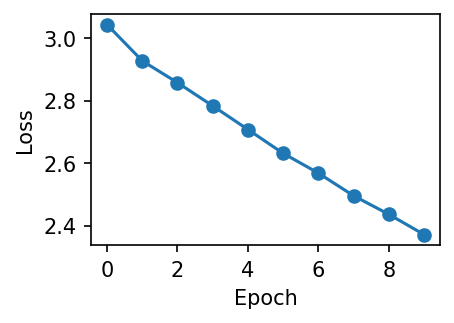

Training accuracy: 0.288
Test accuracy: 0.274


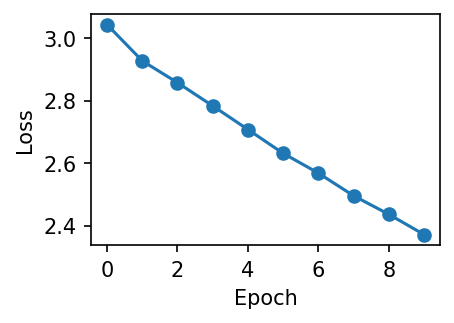

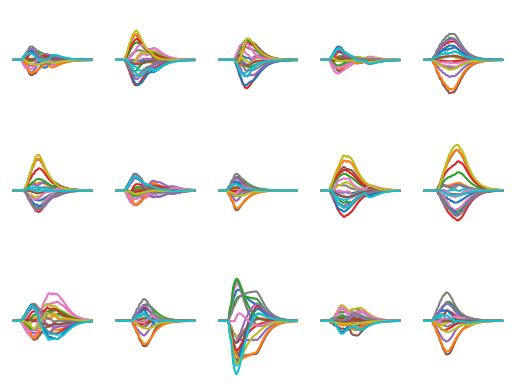

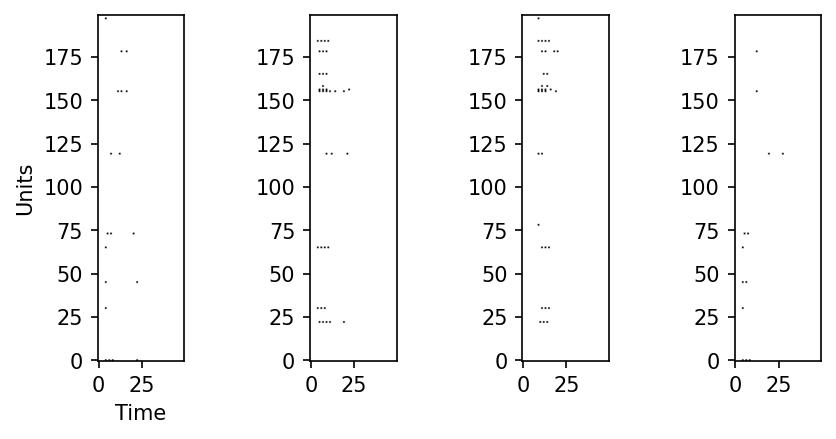

In [13]:
weight_init(weight_scale=0.2)

tau_syn = 5e-3
tau_mem = 10e-3

time_step = 2e-3 # original was 1e-3 but can speed it up a bit without too much loss of performance with 2e-3 - after that it gets a bit dicey
nb_steps = int(100*1e-3/time_step)

loss_hist = train(x_train, y_train, lr=1e-3, nb_epochs=10)

print(f"Training accuracy: {compute_classification_accuracy(x_train,y_train):.3f}")
print(f"Test accuracy: {compute_classification_accuracy(x_test,y_test):.3f}")

visualise_network()